### Load ABF Files

In [3]:
import pyabf
import slopeTools
import abfTools
import plotTools
import statsTools
import numpy as np

abfFilePaths = [
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804007.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804024.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804030.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804043.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804048.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804060.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804066.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805008.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805029.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805035.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20811011.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20811021.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20817012.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20831011.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20831017.abf"
]


### Get Holding Current and Break Data into Segments

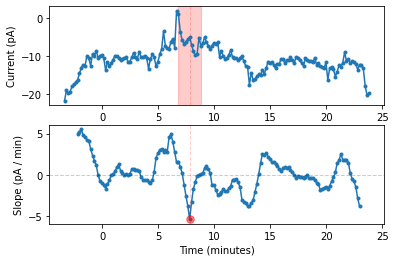

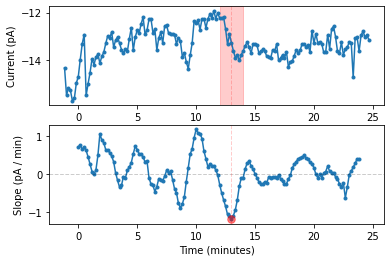

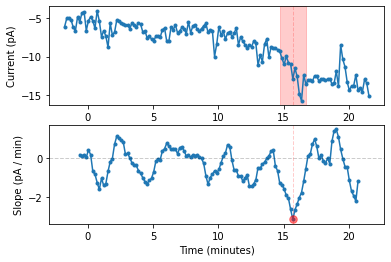

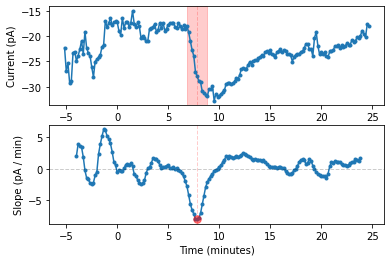

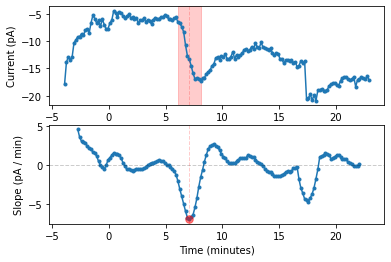

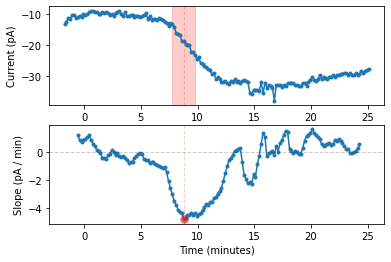

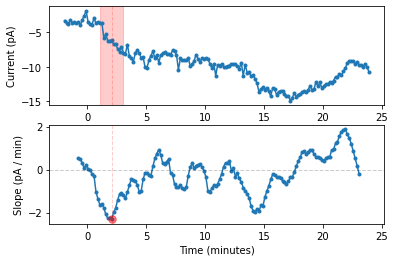

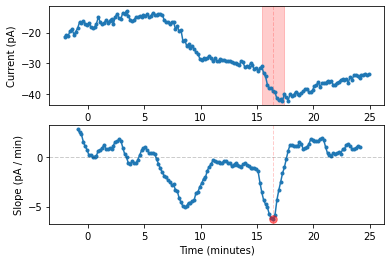

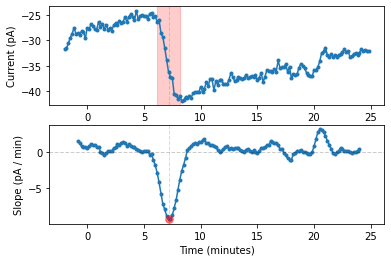

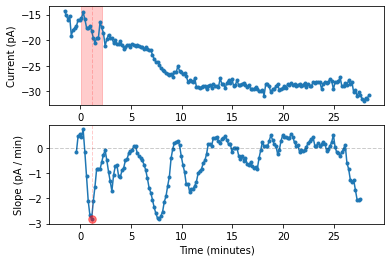

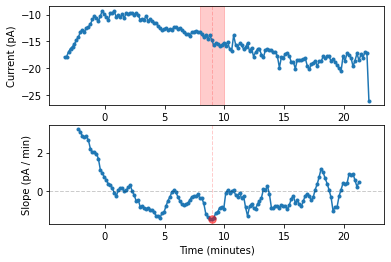

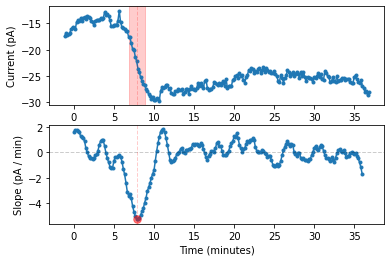

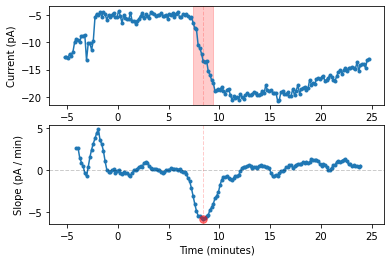

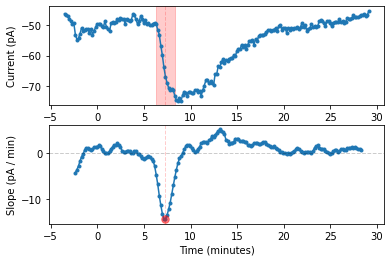

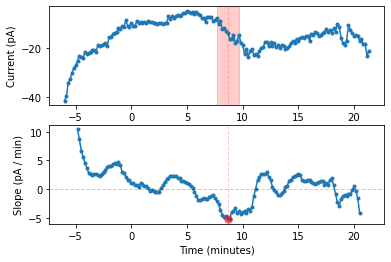

In [4]:
sweepPeriod = 10/60
windowSize = 12

for abfFilePath in abfFilePaths:
    currentsRaw, timesRaw, abfID = abfTools.meanIhold(abfFilePath)
    currentsSegs = statsTools.getMovingWindowSegments(currentsRaw, windowSize)
    slopes = slopeTools.getAllSegmentSlopes(currentsSegs, sweepPeriod)

    # find the minimal slope
    slopeMin = min(slopes)
    indexSlopeMin = slopes.index(slopeMin)

    # find the time point when the minimal slope happens
    tagTime = abfTools.getFirstTagTime(abfFilePath)
    slopeTimeOffset = windowSize * sweepPeriod / 2-(tagTime-5)
    timesSegs = np.arange(len(slopes))*sweepPeriod + slopeTimeOffset
    peakSlopeTime = timesSegs[indexSlopeMin]
    #print(f"the maximal negative slope is {slopeMin} at {peakSlopeTime} min (index {indexSlopeMin})")

    # plot current & slope vs time
    plotTools.currentSlopeTimePlot(currentsRaw, timesRaw,slopes,timesSegs,peakSlopeTime, slopeMin, windowSize, sweepPeriod)
        

To-do:
1. limit a range of time for peak slope searching
2. only show data from x=0
3. report the averaged slope during baseline of each cell
4. saperate cells into responders and non-responders:
    1). peak slope < 0
    2). baseline slope - peak slope > 8?
5. count responders and non-responders, and report a pie plot
6. save slope data as xls to easily import into origin